In [1]:
import pdb
import traceback

import jax
from jax import numpy as jnp
import optax
import wandb
import equinox as eqx

from common_dl_utils.config_creation import Config
import common_jax_utils as cju

wandb.login()

key = jax.random.PRNGKey(12398)
key_gen = cju.key_generator(key)

import PIL
from PIL import Image
from matplotlib import pyplot as plt

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: glukanov2000 (glukanov2000-eindhoven-university-of-technology). Use `wandb login --relogin` to force relogin


In [2]:
def load_image_as_array(path:str)->jax.Array:
    file_extension = path.split('.')[-1]
    if file_extension == 'npy':
        return jnp.load(path)
    # it's ostensibly not just a numpy array so let's use PIL
    with PIL.Image.open(path) as pil_image:
        output = jnp.asarray(pil_image)
    return output

def rgb_to_grayscale(rgb_image:jax.Array):
    gray_image = 0.299*rgb_image[:,:,0] + 0.587*rgb_image[:,:,1] + 0.114*rgb_image[:,:,2]
    gray_image = gray_image.astype(jnp.uint8)  
    return gray_image#/255

In [3]:
def image_grads(image: jax.Array)->jax.Array:
    grads = jnp.stack(jnp.gradient(image, axis=(0, 1)), axis=-1)
    grad_x, grad_y = grads[:,:,0], grads[:,:,1]
    grad_x = (grad_x - jnp.min(grad_x)) / (jnp.max(grad_x) - jnp.min(grad_x))
    grad_y = (grad_y - jnp.min(grad_y)) / (jnp.max(grad_y) - jnp.min(grad_y))
    return jnp.stack([grad_x, grad_y], axis=-1)

def image_laplacian(image: jax.Array)->jax.Array:
    grad_x, grad_y = image_grads(image)
    lap_x = jnp.gradient(grad_x, axis=0)  
    lap_y = jnp.gradient(grad_y, axis=1)  
    return lap_x + lap_y

In [4]:
def gray_parrot_grads(path): 
    return image_grads(rgb_to_grayscale(load_image_as_array(path))) 

def gray_parrot(path):
    return rgb_to_grayscale(load_image_as_array(path))

In [5]:
target_pixels = '[300:600, 550:800]'

In [6]:
config = Config()

# first we specify what the model should look like
config.architecture = './model_components'  # module containing all relevant classes for architectures
# NB if the classes relevant for creating the model are spread over multiple modules, this is no problem
# let config.architecture be the module that contains the "main" model class, and for all other components just specify the module
# or specify the other modules as default modules to the tools in common_jax_utils.run_utils
config.model_type = 'inr_modules.CombinedINR'

config.model_config = Config()
config.model_config.in_size = 2
config.model_config.out_size = 1
config.model_config.terms = [  # CombinedINR uses multiple MLPs and returns the sum of their outputs. These 'terms' are the MLPs
    ('inr_modules.MLPINR.from_config',{
        'hidden_size': 256,
        'num_layers': 5,
        'layer_type': 'inr_layers.SirenLayer',
        'num_splits': 1,
        'activation_kwargs': {'w0': 30.}, # TODO experiment with this
        'initialization_scheme':'initialization_schemes.siren_scheme',
        'initialization_scheme_kwargs': {'w0': 30.}
        #'positional_encoding_layer': ('inr_layers.ClassicalPositionalEncoding.from_config', {'num_frequencies': 10}),
    }),
    # ('inr_modules.MLPINR.from_config',{
    #     'hidden_size': 1024,
    #     'num_layers': 2,
    #     'num_splits': 1,
    #     'layer_type': 'inr_layers.GaussianINRLayer',
    #     'use_complex': False,
    #     'activation_kwargs': {'inverse_scale': 1},
    # })
]
config.model_config.post_processor = ("./inr_utils", "misc.get_first_element")

In [7]:
# create the model
try:
    inr = cju.run_utils.get_model_from_config_and_key(
        prng_key=next(key_gen),
        config=config,
        model_sub_config_name_base='model',
        add_model_module_to_architecture_default_module=False, # since the model is already in the default module specified by 'architecture',
    )
except Exception as e:
    traceback.print_exc()
    print(e)
    print('\n')
    pdb.post_mortem()

In [8]:
# inr

# supervising with gradients

In [9]:
def sample_coordinates(key, image, num_samples):
    coordinates = jax.random.randint(key, (num_samples, 2), minval=0, maxval=jnp.array([image.shape[0], image.shape[1]]))
    return coordinates

def scale_coordinates(height_image, width_image, coordinates):
    x = coordinates[:, 0]  
    y = coordinates[:, 1]  
    x_max = height_image-1
    y_max = width_image-1
    x_normalized = x/x_max
    y_normalized = y/y_max
    return jnp.stack([x_normalized, y_normalized], axis=1)

def gradient_loss(inr, gt_grads, coordinates):
    height_image = gt_grads.shape[0]
    width_image = gt_grads.shape[1]
    inr_grad = eqx.filter_grad(inr)

    # coordinates = coordinates.astype(jnp.int32)
    gt = gt_grads[coordinates[:,0], coordinates[:,1]]

    scaled_coords = scale_coordinates(height_image, width_image, coordinates)
    preds = jax.vmap(inr_grad)(scaled_coords)

    return jnp.sum(jnp.linalg.norm(preds - gt, axis=-1))

# def laplacian_loss(gt_lap, coordinates):
    grad = jax.vmap(inr_grad)(coordinates)    
    lap_x, lap_y = jnp.gradient(grad, axis=(0,1))  
    inr_lap = lap_x + lap_y

    coordinates = coordinates.astype(jnp.int32)
    gt = gt_lap[coordinates[:,0], coordinates[:,1]]
    
    return jnp.sum(jnp.linalg.norm(inr_lap - gt, axis=-1))

# def regular_loss(inr, gt, coordinates):
    preds = jax.vmap(inr)(coordinates)
    coordinates = coordinates.astype(jnp.int32)
    gt = gt[coordinates[:,0], coordinates[:,1]]
    return jnp.sum(jnp.linalg.norm(preds - gt, axis=-1))

In [10]:
# scale_coordinates(1356, 2040, sample_coordinates(next(key_gen), gray_parrot('example_data/parrot.png'), 10))

In [11]:
def train(inr, gt_grads, nr_steps, nr_coordinates, key_generator):

    optimizer = optax.adam(learning_rate = 1e-5)
    opt_state = optimizer.init(eqx.filter(inr, eqx.is_array))

    @eqx.filter_jit
    def train_step(inr, opt_state, coordinates):
        loss, grad = eqx.filter_value_and_grad(gradient_loss)(inr, gt_grads, coordinates)
        updates, opt_state = optimizer.update(grad, opt_state)
        inr = eqx.apply_updates(inr, updates)
        return inr, opt_state, loss

    losses = nr_steps*[None]
    for step in range(nr_steps):
        coordinates = sample_coordinates(next(key_generator), gt_grads, nr_coordinates)
        inr, opt_state, loss = train_step(inr, opt_state, coordinates)
        losses[step] = loss
        
        # if step % 100 == 0: 
        #     print(losses[step])

    return inr, losses

In [12]:
inr, losses = train(
      inr, 
      gray_parrot_grads('example_data/parrot.png')[300:600, 550:800], 
      nr_steps=2000,
      nr_coordinates=1000, 
      key_generator=key_gen
      )

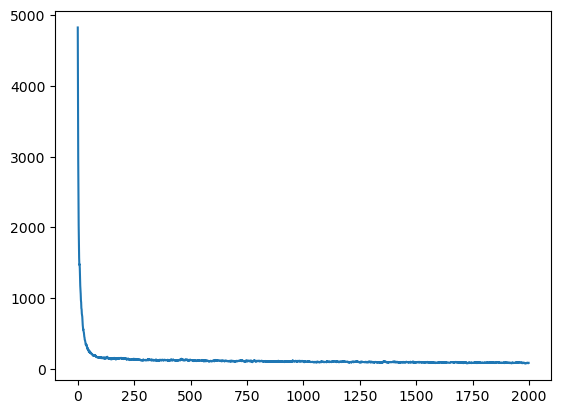

In [13]:
plt.plot(losses)
plt.show()

In [14]:
all_coordinates = jnp.stack(jnp.meshgrid(jnp.arange(0, 1356, 1), jnp.arange(0, 2040, 1), sparse=False, indexing='ij'), axis=-1)
all_coordinates_flat = jax.lax.reshape(all_coordinates, (all_coordinates.shape[0]*all_coordinates.shape[1], 2))
all_coordinates_scaled = scale_coordinates(1356, 2040, all_coordinates_flat)


corner_parrot = all_coordinates[300:600, 550:800]
corner_parrot_flat = jax.lax.reshape(corner_parrot, (corner_parrot.shape[0]*corner_parrot.shape[1], 2))
corner_parrot_scaled = scale_coordinates(300, 250, corner_parrot_flat)

# jnp.reshape(corner_parrot_flat, corner_parrot.shape) == corner_parrot

In [15]:
preds = jax.vmap(inr)(corner_parrot_scaled)
preds = jnp.reshape(preds, corner_parrot.shape[:-1])

# preds = jax.vmap(inr)(all_coordinates_scaled)
# preds = jnp.reshape(preds, all_coordinates.shape[:-1])

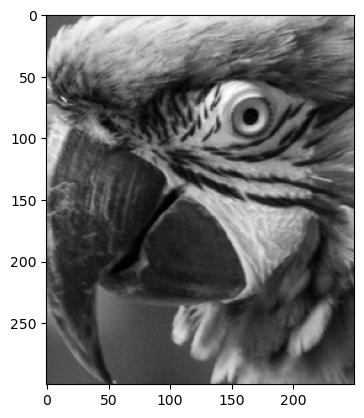

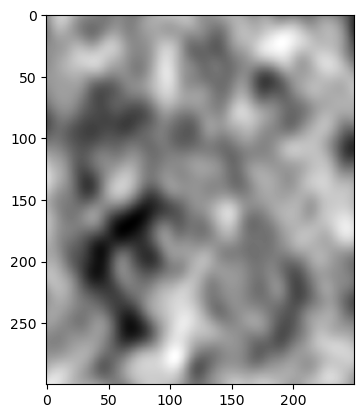

In [16]:
plt.imshow(gray_parrot('example_data/parrot.png')[300:600, 550:800], cmap='gray')
plt.show()
plt.imshow(preds, cmap='gray')
plt.show()

In [17]:
c = sample_coordinates(next(key_gen), gray_parrot_grads('example_data/parrot.png')[300:600, 550:800], 5)
sc = scale_coordinates(600, 800, c)
print(c, '\n', sc, '\n')

inr_grad = eqx.filter_grad(inr)
# gray_parrot_grads('example_data/parrot.png')[c[:,0], c[:,1]] - jax.vmap(inr_grad)(sc)

print(gray_parrot('example_data/parrot.png')[c[:,0], c[:,1]]/255, '\n', jax.vmap(inr)(sc))

[[ 95 223]
 [193 195]
 [258 188]
 [136 195]
 [205 239]] 
 [[0.15859766 0.27909887]
 [0.32220367 0.24405508]
 [0.43071786 0.23529412]
 [0.22704507 0.24405508]
 [0.34223706 0.2991239 ]] 

[0.61568624 0.41960782 0.5333333  0.52941173 0.5686274 ] 
 [1.1809201 1.2472837 1.2893875 1.1910763 1.2846317]


In [18]:
# plt.imshow(corner_parrot[:,:,0], cmap='gray')
# plt.show()
# plt.imshow(jnp.reshape(corner_parrot_flat, corner_parrot.shape)[:,:,0], cmap='gray')
# plt.show()

In [19]:

# plt.imshow(jnp.reshape(corner_parrot_flat, corner_parrot.shape)[:,:,1], cmap='gray')
# plt.show()
# plt.imshow(corner_parrot[:,:,1], cmap='gray')
# plt.show()

In [20]:
# def create_B(N, dim_input):
#         # all possible values in the range [-N, N]
#         grid_ranges = [jnp.arange(-N, N+1) for _ in range(dim_input)]
        
#         # create a grid of all combinations of the values in [-N, N]
#         grid_mesh = jnp.meshgrid(*grid_ranges, indexing='ij')
        
#         # stack combinations into a matrix
#         B = jnp.stack([g.flatten() for g in grid_mesh], axis=-1)

#         # apply infinity norm constraint ||n||_∞ ≤ N 
#         mask = jnp.max(jnp.abs(B), axis=1) <= N
#         B = B[mask]
        
#         # rows where last component is negative
#         last_is_negative = B[:, -1] < 0  
#         # rows that are entirely zero except for the last component
#         all_zeros_except_last = jnp.all(B[:, :-1] == 0, axis=1)  
        
#         # combine the conditions
#         set_H = ~(all_zeros_except_last & last_is_negative)  
#         B = B[set_H]

#         return B

In [21]:
# def create_B(N, dim_input):
#     """
#     Generates the integer lattice mapping B, ensuring its size matches Equation 12.

#     Parameters:
#     - N (int): Frequency bound.
#     - dim_input (int): Input dimension.

#     Returns:
#     - B (jax.numpy.ndarray): The integer lattice mapping matrix.
#     """
#     # Step 1: Generate all integer values in range [-N, N] for each dimension
#     grid_ranges = [jnp.arange(-N, N + 1) for _ in range(dim_input)]
    
#     # Step 2: Create a full grid of combinations
#     grid_mesh = jnp.meshgrid(*grid_ranges, indexing='ij')
    
#     # Step 3: Flatten and stack into a matrix B of shape (m, dim_input)
#     B = jnp.stack([g.flatten() for g in grid_mesh], axis=-1)

#     # Step 4: Apply infinity norm constraint ||n||_∞ ≤ N
#     mask = jnp.max(jnp.abs(B), axis=1) <= N
#     B = B[mask]

#     # Step 5: Construct Set H for Exclusion
#     # Identify where all previous elements (n1, ..., n_{j-1}) are zero
#     zero_prefix_mask = jnp.cumprod(B == 0, axis=1, dtype=jnp.int32)

#     # Find cases where a negative component appears after a sequence of leading zeros
#     invalid_mask = jnp.any((zero_prefix_mask[:, :-1] == 1) & (B[:, 1:] < 0), axis=1)

#     # Remove elements of H
#     B = B[~invalid_mask]

#     return B

In [22]:
# def apply_alpha_to_B(B, alpha):
    
#     norms = jnp.linalg.norm(B, axis=1)
    
#     max_alpha = norms.max()
#     if alpha > max_alpha:
#         alpha = max_alpha

#     def w_alpha(z):
#         return jnp.where(
#             alpha - z < 0,
#             0, jnp.where(alpha-z<=1, 0.5*(1-jnp.cos((alpha-z)*jnp.pi)), 1),
#         )

#     weights = w_alpha(norms)

#     weighted_B = B * weights[:, None]

#     return weighted_B, max_alpha

In [23]:
# B = create_B(8,3)
# # B[round(B.shape[0]/2)-80: round(B.shape[0]/2)-60, :]
# # B[round(B.shape[0]/2)-10: round(B.shape[0]/2)+10, :]
# B[jnp.linalg.norm(B, axis=1)==1]

In [24]:
# weighted_B = apply_alpha_to_B(B, 2)
# mask = jnp.linalg.norm(weighted_B, axis=1) == 0

# # weighted_B[round(B.shape[0]/2)-20: round(B.shape[0]/2)+20, :]
# weighted_B[mask]

In [25]:
# import jax.numpy as jnp
# import jax.random as random

# def prune_B_and_W(B, W, target_ratio=0.5):
#     """
#     Dynamically prunes B by retaining a ratio of rows based on the magnitude of learned weights.
#     Also returns the corresponding columns of W that were kept or removed.

#     Parameters:
#     - B (jax.numpy.ndarray): The integer lattice mapping matrix with shape (m, in_size).
#     - W (jax.numpy.ndarray): The learned weight matrix with shape (out_size, 2m).
#     - target_ratio (float): Ratio of rows to retain (e.g., 0.5 means retain 50% of rows).

#     Returns:
#     - pruned_B (jax.numpy.ndarray): The pruned B matrix of shape (retained_rows, in_size).
#     - removed_B (jax.numpy.ndarray): The removed rows from B.
#     - pruned_W (jax.numpy.ndarray): The pruned W matrix (out_size, 2 * retained_rows).
#     - removed_W (jax.numpy.ndarray): The removed columns from W (out_size, 2 * removed_rows).
#     """
#     m = B.shape[0]  # Number of frequencies in B

#     # Compute the importance of each frequency (sum norms for sine and cosine components)
#     importance_scores = jnp.linalg.norm(W[:, :m], axis=0) + jnp.linalg.norm(W[:, m:], axis=0)

#     # Calculate the number of rows to retain
#     target_size = jnp.ceil(target_ratio * m).astype(int)

#     # Get indices of the top rows based on importance scores
#     top_indices = jnp.argsort(importance_scores)[-target_size:]#.astype(int)

#     # Get indices of rows to remove
#     remove_indices = jnp.argsort(importance_scores)[:-target_size]#.astype(int)

#     # Select the top rows to keep
#     pruned_B = B[top_indices]
#     removed_B = B[remove_indices]

#     # Select the corresponding weights in W
#     pruned_W = jnp.concatenate([W[:, top_indices], W[:, top_indices + m]], axis=1)
#     removed_W = jnp.concatenate([W[:, remove_indices], W[:, remove_indices + m]], axis=1)

#     return pruned_B, removed_B, pruned_W, removed_W

# m = 50          
# in_size = 3     
# out_size = 5    
# target_ratio = 0.5   

# key = next(key_gen)
# B = random.randint(key, shape=(m, in_size), minval=-5, maxval=6)

# key = next(key_gen)
# W = random.normal(key, shape=(out_size, 2 * m))

# pruned_B, removed_B, pruned_W, removed_W = prune_B_and_W(B, W, target_ratio=target_ratio)

# print("Original B size:", B.shape[0])
# print("Pruned B size:", pruned_B.shape[0])
# print("Removed B size:", removed_B.shape[0])
# print("\nPruned B (first 10 rows):\n", pruned_B[:10])
# print("\nRemoved B (first 10 rows):\n", removed_B[:10])

# print("\nPruned W shape:", pruned_W.shape)
# print("Removed W shape:", removed_W.shape)

# print("\nPruned W (first 5 columns):\n", pruned_W[:, :5])
# print("\nRemoved W (first 5 columns):\n", removed_W[:, :5])

In [26]:
# def expected_B_size(N, dim_input):

#     first_term = (N + 1) * (2 * N + 1) ** (dim_input - 1)
#     sum_term = sum(N * (2 * N + 1) ** l for l in range(dim_input - 2))
#     return first_term - sum_term


# def check_B_size(create_B, N, dim_input):
#     expected_size = expected_B_size(N, dim_input)
#     B = create_B(N, dim_input)
#     actual_size = B.shape[0]
#     return expected_size == actual_size, (expected_size, actual_size)

# N = 4
# dim_input = 4

# is_correct, (expected_size, actual_size) = check_B_size(create_B, N, dim_input)
# print(f"Size Check: {is_correct}")
# print(f"Expected B Size: {expected_size}, Actual B Size: {actual_size}")